## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

'''setting seed'''
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

## Load and Extract data

In [2]:
import zipfile

zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("../C:\Users\dell\Desktop\mini project/dogs-vs-cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 5-6: truncated \UXXXXXXXX escape (3222899960.py, line 6)

In [3]:
TRAIN_DIR_PATH = './train'
file_names = os.listdir(TRAIN_DIR_PATH)
print('There are {} number of images in directory.'.format(len(file_names)))

There are 25000 number of images in directory.


In [4]:
def to_dataframe(file_names):
    files, labels = list(), list()
    for file in file_names:
        files.append(file)
        labels.append(file[:3])
    df = pd.DataFrame({'filename':files, 'label':labels})
    return df

df = to_dataframe(file_names)

In [5]:
df.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


## Analyze data

data set label distribution:
 cat    12500
dog    12500
Name: label, dtype: int64


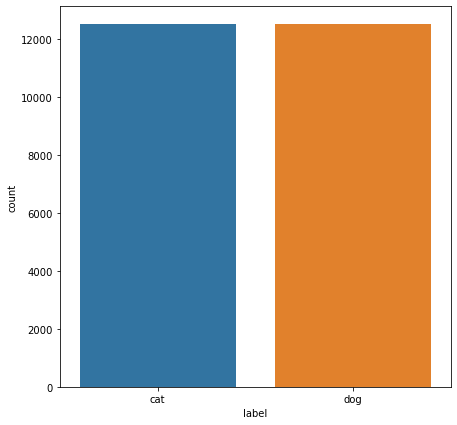

In [6]:
print('data set label distribution:\n',df['label'].value_counts())

plt.figure(figsize=(7,7))
sns.countplot(x = df['label'])
plt.show()

In [7]:
cat = [file for file in file_names if file[:3]=='cat']
dog = [file for file in file_names if file[:3]=='dog']

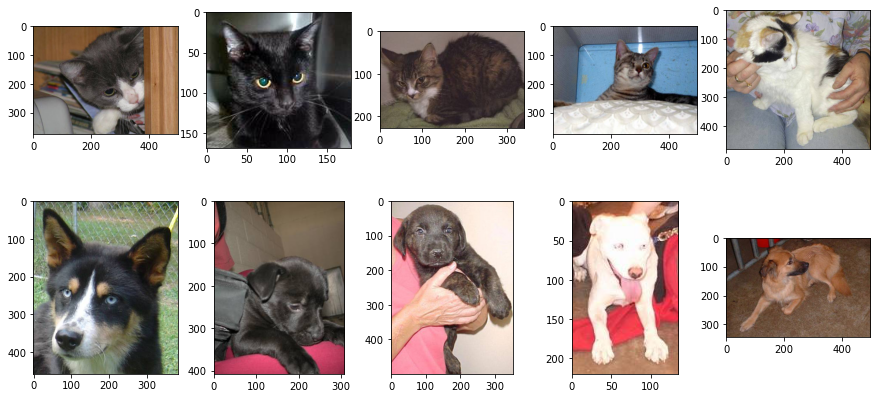

In [8]:
plt.figure(figsize=(15,7))
for i, c in enumerate(np.random.randint(0,len(cat),5), start=1):
    im = img.imread('./train/'+cat[c])
    plt.subplot(2,5,i)
    plt.imshow(im)
    
for i, c in enumerate(np.random.randint(0,len(dog),5), start=6):
    im = img.imread('./train/'+dog[c])
    plt.subplot(2,5,i)
    plt.imshow(im)

## Split data

In [9]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(df, test_size=0.2,random_state=seed)

In [10]:
train_set.shape, valid_set.shape

((20000, 2), (5000, 2))

train set distribution:
 cat    10004
dog     9996
Name: label, dtype: int64

valid set distribution:
 dog    2504
cat    2496
Name: label, dtype: int64



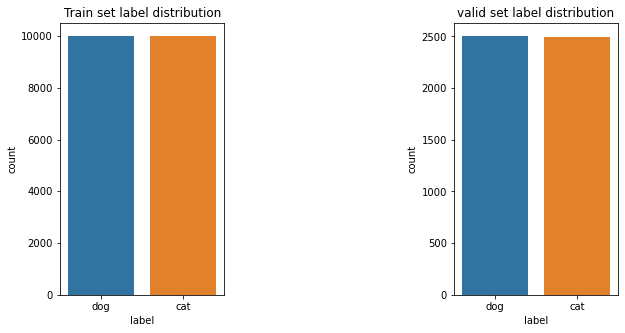

In [11]:
print('train set distribution:\n',train_set['label'].value_counts())
print('\nvalid set distribution:\n',valid_set['label'].value_counts())
print()

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.countplot(x=train_set['label'], order=['dog','cat'])
plt.title('Train set label distribution')

plt.subplot(1,3,3)
sns.countplot(x=valid_set['label'], order=['dog','cat'])
plt.title('valid set label distribution')
plt.show()

## Image data Generator and Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

WIDTH, HEIGHT = 150, 150
batch_size = 32

In [13]:
train_datagenerator = ImageDataGenerator(rotation_range=15, 
                                  rescale=1./255, 
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

training_data = train_datagenerator.flow_from_dataframe(dataframe=train_set, 
                                                        directory='./train',
                                                       x_col='filename',
                                                       y_col='label',
                                                       target_size=(WIDTH, HEIGHT),
                                                       class_mode='categorical',
                                                       batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [14]:
valid_datagenerator = ImageDataGenerator(rescale=1./255)
validation_data = valid_datagenerator.flow_from_dataframe(dataframe=valid_set,
                                                         directory='./train',
                                                         x_col='filename',
                                                         y_col='label',
                                                         target_size=(WIDTH,HEIGHT),
                                                         class_mode='categorical',
                                                         batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


## Making CNN Model

In [15]:
from tensorflow.keras.layers import *
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential()

model.add(DefaultConv2D(filters=32, kernel_size=5, input_shape=(WIDTH, HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(DefaultConv2D(filters=64))
model.add(DefaultConv2D(filters=64))
model.add(MaxPooling2D(pool_size=2))

model.add(DefaultConv2D(filters=128))
model.add(DefaultConv2D(filters=128))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 128)       7

## Transfer Learning

In [17]:
base_model = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(WIDTH,HEIGHT,3))
base_model.trainable = False ## Not trainable weights

In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [19]:
from tensorflow.keras.layers import *

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [20]:
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(training_data,
            epochs=5,
            validation_data=validation_data,
            validation_steps=valid_set.shape[0]//batch_size,
            steps_per_epoch=train_set.shape[0]//batch_size, 
            )

Epoch 1/5
322/625 [==============>...............] - ETA: 1:25:54 - loss: 0.4901 - accuracy: 0.7622

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()